# Forecasting burned area with SMLFire1.0

Author: Jatan Buch (v1, 231107)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
from numpy.lib.stride_tricks import sliding_window_view
from scipy import stats, interpolate
from scipy.optimize import minimize
from scipy.special import gamma
from sklearn.linear_model import LinearRegression
from math import factorial
import itertools
from copy import deepcopy

import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#self-libraries
from fire_utils import *
from ml_utils import *
from ssf_utils import *

#modules for data processing and gradient boosting 
from ngboost import NGBRegressor, distns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.metrics import mean_squared_error, r2_score
import pickle # for saving and loading models
from pathlib import Path
import shap

#modules for neural network
import tensorflow as tf
import tensorflow_probability as tfp
tfd= tfp.distributions

from datetime import datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from plot_params_mpl39 import params
import matplotlib.pylab as pylab
import seaborn as sns
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

## Loading observed and forecast climate predictors

In [2]:
# load in data frame with observed climate, vegetation, and human predictors

target_yr= 2023
rescale_flag= True
if target_yr != 2023:
    clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2022_rescaled_data.h5')
    sys_no= None
else:
    clim_df= pd.read_hdf('../data/clim_fire_freq_12km_w2023_rescaled_data.h5')
    climdf= deepcopy(clim_df)
    sys_no= 51
clim_df.loc[clim_df[clim_df.fire_freq > 1].index, 'fire_freq']= np.ones(len(clim_df[clim_df.fire_freq > 1].index), dtype= np.int64)

# also load in wildfire_df

wildfire_df= pd.read_hdf('../data/firelist/wildfire_df_wumi2_modis.h5', key= 'df')
wildfire_df['fire_month']= (wildfire_df['final_year']*12 + wildfire_df['final_month']) - (1984*12 + 1) # no. of months since 1984-01

reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW Mts.", 6: "Columbia Plateau", 7:"Northern Rockies", \
          8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
          15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}

In [3]:
pred_var_arr= ['Tmax', 'Prec', 'VPD', 'Tmin'] #'VPD', 'FFWI',
if target_yr == 'baseline':
    pred_mon_arr= baseline_mon_arr_func(start_yr= 2001, end_yr= 2019, mindx= [5, 6, 7, 8, 9]).values # np.sort(np.append(np.append(np.arange(209, 426, 12), np.arange(210, 427, 12)), np.arange(211, 428, 12))) #2001-2020 
else:
    pred_mon_arr=  np.array([460, 461, 462, 463, 464]) - (2022 - target_yr)*12  #464
firemon_pred_flag= 'dynamical_forecasts' #'dynamical_forecasts' #'observations'
ens_no= 11
pred_drop_cols= ['SWE_mean', 'SWE_max', 'AvgSWE_3mo']

X_pred_ur_df, X_pred_test_df= fire_pred_df_func(clim_df, target_yr, pred_mon_arr, pred_var_arr, firemon_pred_flag, sys_no= sys_no, ens_no= ens_no, freq_flag= 'prediction')

100%|██████████| 2/2 [01:52<00:00, 56.01s/it]


## Fire size trends

In [4]:
sav_freq_flag= False
if sav_freq_flag:
    target_yr= 2022
    firemon_pred_flag= 'dynamical_forecasts'
    ens_no= 35
    freq_id= '08_07_23'
    seed= 654

    pred_mon_arr=  np.array([461, 462, 463]) - (2022 - target_yr)*12

    if firemon_pred_flag == 'observations':
        mdn_freq_test_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag)
        freq_loc_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%target_yr + '_%s.h5'%firemon_pred_flag)
        X_pred_ur_df= pd.read_hdf('../sav_files/ssf_pred_files/%s_dataframe'%freqlabel + '_%s'%freq_id + '_%d'%seed +  '_obs_%d.h5'%target_yr)
    else:
        mdn_freq_test_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/mdn_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr)
        freq_loc_df= pd.read_hdf('../sav_files/fire_freq_pred_dfs/' + '%s'%firemon_pred_flag + '/freq_loc_ssf_%s'%freq_id + '_%d'%seed +  '_fire_freq_%d'%ens_no + '_%d.h5'%target_yr)
        X_pred_ur_df= pd.read_hdf('../sav_files/ssf_pred_files/' + '%s'%firemon_pred_flag + '/pred_fire_freq_dataframe_%s'%freq_id + '_%d'%seed +  '_df_%d'%ens_no + '_%d.h5'%target_yr)

In [5]:
nregions= 18
X_sizes_train, X_sizes_val, y_sizes_train, y_sizes_val, fire_size_train, fire_size_test, X_sizes_test, y_sizes_test= fire_size_data(res= '12km', \
                            dropcols= drop_col_func(mod_type= 'normal', add_var_flag= True, add_var_list= ['SWE_max', 'SWE_mean', 'AvgSWE_3mo', 'Delta_T']), \
                            start_month= 444, tot_test_months= 24, threshold= 4, scaled= True, tflag= True, final_year= 2022) #tflag= True; scaled= True, rh_flag= True
X_sizes_train_df= pd.concat([X_sizes_train, X_sizes_val], sort= False).reset_index().drop(columns=['index'])
X_sizes_tot= pd.concat([X_sizes_train_df, X_sizes_test], sort= False).reset_index().drop(columns=['index'])
fire_size_tot= pd.concat([fire_size_train, fire_size_test], sort= False).reset_index().drop(columns=['index'])

max_fire_train_arr= []
sum_fire_train_arr= []
for r in tqdm(range(nregions)):
    max_fire_train_arr.append(np.max(np.concatenate([fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6 \
                                    for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()])))
    #sum_fire_train_arr.append(np.max([np.sum(fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').get_group(k).fire_size.to_numpy()/1e6) \
    #                                for k in fire_size_train.groupby('reg_indx').get_group(r+1).groupby('fire_month').groups.keys()]))
    
max_fire_train_arr= np.asarray(max_fire_train_arr)
sum_fire_train_arr= max_fire_size_sum_func(fire_size_df= fire_size_tot, final_month= 480) #update final month for 2023!

100%|██████████| 18/18 [00:01<00:00, 15.49it/s]


### Burned area prediction and plotting

In [12]:
size_id= '08_21_23'
mdn_gpd_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
mdn_gpd_ext_mod= tf.keras.models.load_model('../sav_files/fire_size_mods/mdn_gpd_ext_size_model_%s'%size_id, custom_objects= {'gpd_loss': gpd_loss, 'gpd_accuracy': gpd_accuracy})
X_sizes_test_df= X_pred_ur_df.drop(columns= ['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max7', 'Avgprec_4mo',  'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', \
                                                                                            'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness', 'X', 'Y', 'fire_freq', 'pred_fire_prob'])

KeyError: "['Solar', 'Ant_Tmax', 'RH', 'Ant_RH', 'RH_min3', 'FFWI_max7', 'Avgprec_4mo', 'Avgprec_2mo', 'AvgVPD_4mo', 'AvgVPD_2mo', 'Tmax_max7', 'VPD_max7', 'Tmin_max7', 'Elev', 'Delta_T', 'CAPE', 'Southness', 'X', 'Y', 'pred_fire_prob'] not found in axis"

In [19]:
sizelabel= 'gpd'
if sizelabel == 'gpd_ext':
    reg_gpd_ml_pred_size_df= grid_ssf_size_func(mdn_model= mdn_gpd_ext_mod, stat_model= gpd_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, pred_mon_flag= True, pred_mons= pred_mon_arr, \
                                        nsamps= 1000, loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_sizes_test_df)
elif sizelabel == 'gpd':
    reg_gpd_ml_pred_size_df= grid_ssf_size_func(mdn_model= mdn_gpd_mod, stat_model= gpd_model, max_size_arr= max_fire_train_arr, sum_size_arr= sum_fire_train_arr, pred_mon_flag= True, pred_mons= pred_mon_arr, \
                                        nsamps= 1000, loc_df= freq_loc_df, ml_freq_df= mdn_freq_test_df, X_test_dat= X_sizes_test_df)
if firemon_pred_flag == 'observations':
    reg_gpd_ml_pred_size_df.to_hdf('../sav_files/fire_size_pred_dfs/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                                    + '_%s'%sizelabel + '_%s.h5'%target_yr, key= 'df', mode= 'w')
else:
    reg_gpd_ml_pred_size_df.to_hdf('../sav_files/fire_size_pred_dfs/' + '%s'%firemon_pred_flag + '/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel.split('_')[1:])) \
                                                                                                            + '_%s'%sizelabel + '_%d'%ens_no + '_%s.h5'%target_yr, key= 'df', mode= 'w')

  0%|          | 0/18 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  6%|▌         | 1/18 [00:00<00:02,  7.31it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 4/18 [00:00<00:00, 14.56it/s]

1/1 [==============================] - 0s 12ms/step


 50%|█████     | 9/18 [00:00<00:00, 25.42it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 12/18 [00:00<00:00, 19.55it/s]

1/1 [==============================] - 0s 13ms/step


 83%|████████▎ | 15/18 [00:00<00:00, 16.06it/s]

1/1 [==============================] - 0s 13ms/step


 94%|█████████▍| 17/18 [00:01<00:00, 14.12it/s]

1/1 [==============================] - 0s 13ms/step


100%|██████████| 18/18 [00:01<00:00, 14.59it/s]


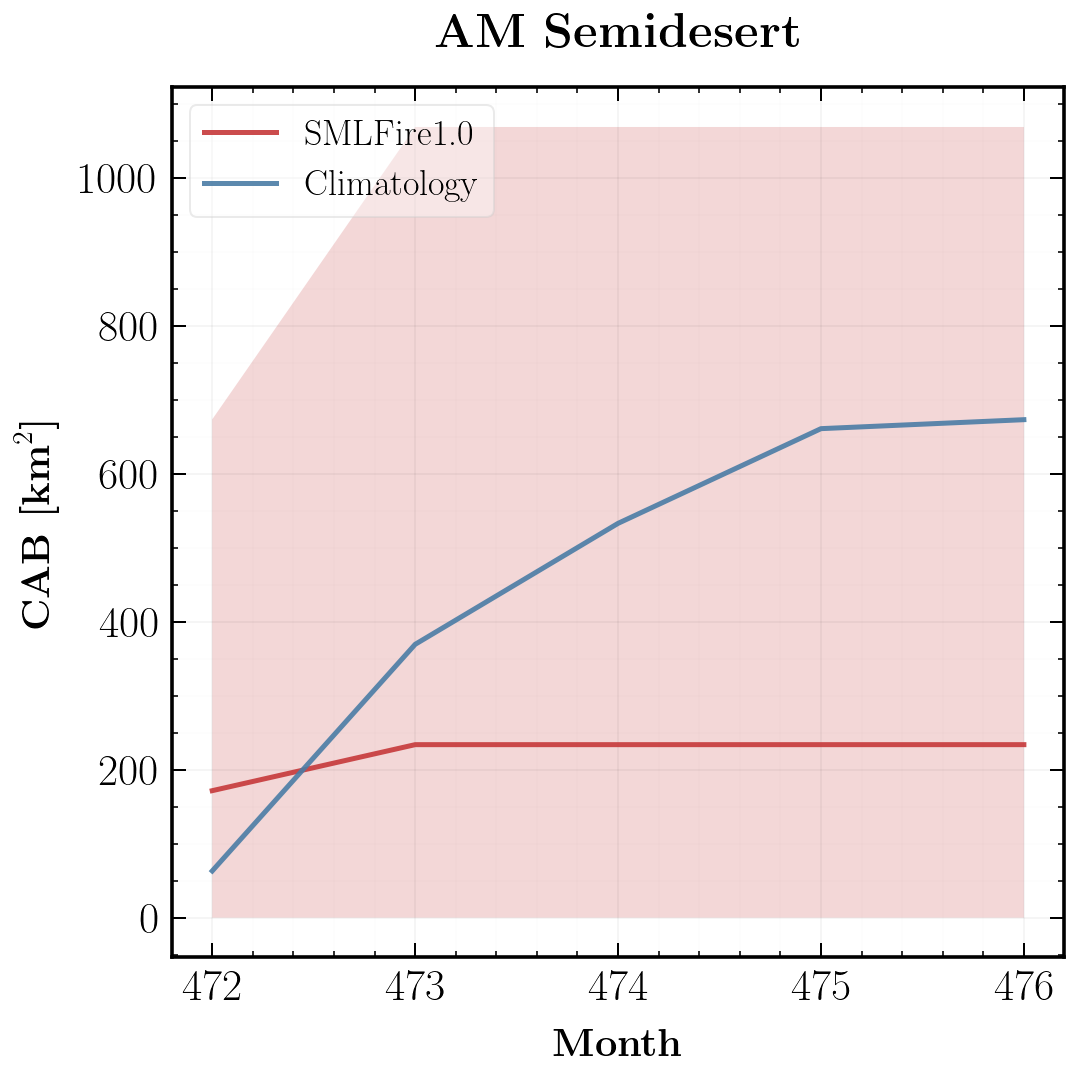

In [26]:
rindx= 10
plt_reg= 'aznmmts'
plot_yr= 2022
fig, ax= plt.subplots(1, 1, figsize=(8, 8))

ax.plot(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['month'], np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['mean_size']), \
                                                                                                                   linewidth= 2.5, label= 'SMLFire1.0')
ax.fill_between(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['month'], np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['high_1sig_size']), \
                                                                               np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx)['low_1sig_size']), alpha=0.2)
ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_climatology(fire_size_df= fire_size_tot, pred_mons= [5, 6, 7, 8, 9],\
                                                                                                                    regindx= rindx)), linewidth= 2.5, label= 'Climatology')
#ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_ts(fire_size_df= fire_size_tot, pred_mons= pred_mon_arr, regindx= rindx)), \
#                                                                                                                    linestyle= '--', color= 'black', linewidth= 3, label= 'Observations')

ax.set_ylabel(r'{\bf CAB [${\bf km}^2$]}', fontsize= 20, labelpad= 10);
ax.set_xlabel(r'{\bf Month}', fontsize= 20, labelpad= 10);
#ax.set_ylim(-100, 3000)

ax.set_title(r'{\bf %s}'%reg_name[rindx], fontsize= 24, pad= 20);
ax.tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
ax.legend(loc= 'upper left', frameon= True, fontsize= 18);
ax.grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
ax.grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
#plt.savefig('../plots/smlfire_output/dynamical_forecasts/pred_fire_size_%s'%size_id + '_%d_'%plot_yr + 'obs_%s.png'%plt_reg, bbox_inches='tight', dpi= 200);

### Ensemble burned area plots

In [140]:
sizelabel= ['gpd', 'gpd_ext']
freqlabel= ['pred_mean_freq', 'pred_high_2sig'] # 'pred_high_2sig'
size_id= '08_21_23'
ens_no_arr= np.arange(0, 51, 1)

100%|██████████| 51/51 [00:00<00:00, 252.37it/s]


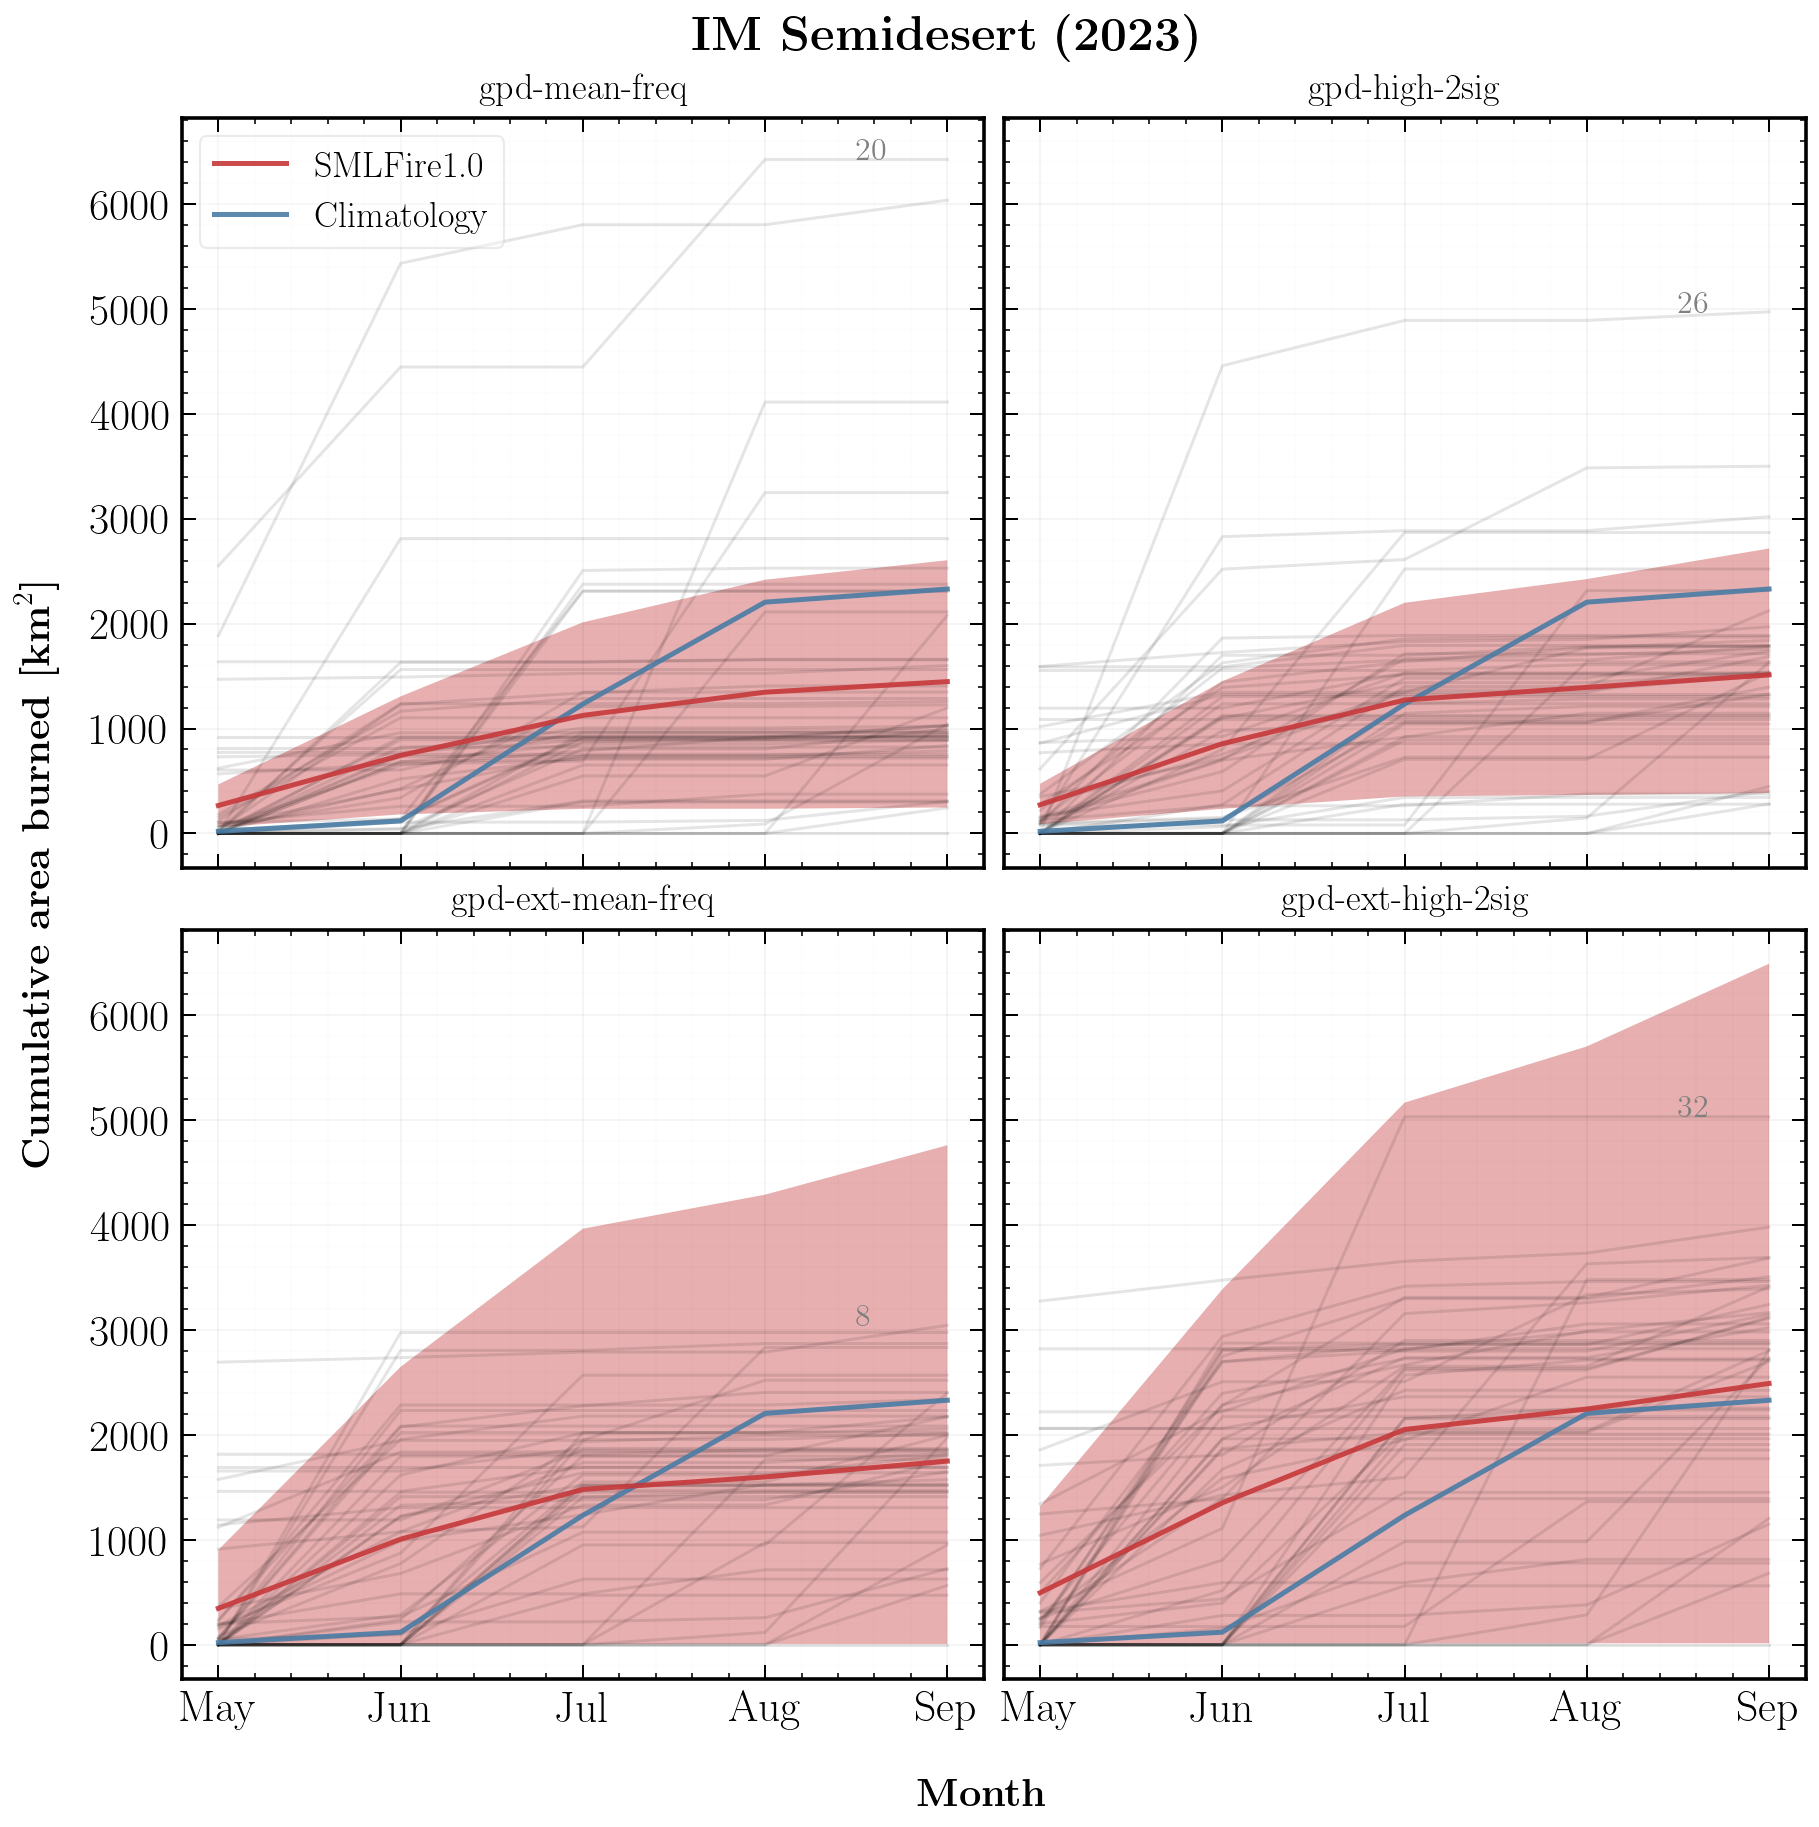

In [147]:
rindx= 12
plt_reg= 'pnwmts'
plot_yr= 2023
plt.rcParams['figure.constrained_layout.use'] = True
fig, ax= plt.subplots(2, 2, figsize=(12, 12), sharey= True)
fig.text(-0.04, 0.5, r'{\bf Cumulative area burned [${\bf km}^2$]}', va='center', rotation='vertical', fontsize= 20);
fig.text(0.52, -0.04, r'{\bf Month}', ha='center', fontsize= 20)

for i in range(2):
    for j in range(2):
        reg_gpd_ml_pred_size_df= pd.DataFrame([])
        for enp in tqdm(ens_no_arr):
            tmp_df= pd.read_hdf('../sav_files/fire_size_pred_dfs/' + '%s'%firemon_pred_flag + '/pred_size_df_ml_gpd_%s'%size_id + '_%s'%('_'.join(freqlabel[j].split('_')[1:])) \
                                                                                                                    + '_%s'%sizelabel[i] + '_%d'%enp + '_%s.h5'%target_yr)
            reg_gpd_ml_pred_size_df= pd.concat([reg_gpd_ml_pred_size_df, tmp_df], axis= 0)
        ens_no_df= pd.DataFrame({'ens_no': np.repeat(ens_no_arr, len(tmp_df))})
        reg_gpd_ml_pred_size_df= pd.concat([reg_gpd_ml_pred_size_df.reset_index(), ens_no_df], axis= 1).drop(columns= ['index'])
        max_ens_no= reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx).groupby('ens_no').mean()['mean_size'].idxmax()

        ax[i, j].plot(pred_mon_arr, np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx).groupby('month').mean()['mean_size']).to_numpy(), \
                                                                                                                        linewidth= 2.5, label= 'SMLFire1.0', zorder= 10)
        ax[i, j].fill_between(pred_mon_arr, np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx).groupby('month').mean()['high_1sig_size']), \
                                                                np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx).groupby('month').mean()['low_1sig_size']), alpha=0.4)
        for enp in ens_no_arr:
            ax[i, j].plot(pred_mon_arr, np.cumsum(reg_gpd_ml_pred_size_df.groupby('ens_no').get_group(enp).groupby('reg_indx').get_group(rindx)['mean_size']).to_numpy(), c= 'black', alpha= 0.1, linewidth= 1.5, zorder= 1)
        ax[i, j].plot(pred_mon_arr, np.cumsum(obs_burned_area_climatology(fire_size_df= fire_size_tot, pred_mons= [5, 6, 7, 8, 9], regindx= rindx)), linewidth= 2.5, label= 'Climatology', zorder= 5)
        #ax.plot(pred_mon_arr, np.cumsum(obs_burned_area_ts(fire_size_df= fire_size_tot, pred_mons= pred_mon_arr, regindx= rindx)), \
        #                                                                                                                    linestyle= '--', color= 'black', linewidth= 3, label= 'Observations')
        # if i==0 and j==0:
        #     ax[i, j].set_ylabel(r'{\bf CAB [${\bf km}^2$]}', fontsize= 20, labelpad= 10);
        #ax[0, 0].set_xlabel(r'{\bf Month}', fontsize= 20, labelpad= 10);
        ax[i, j].set_xticks(pred_mon_arr)
        if i==1:
            ax[i, j].set_xticklabels(['May', 'Jun', 'Jul', 'Aug', 'Sep']);
        else:
            ax[i, j].set_xticklabels([]);
        #ax.set_ylim(-100, 3000)
        ax[i, j].text(475.5, np.cumsum(reg_gpd_ml_pred_size_df.groupby('reg_indx').get_group(rindx).groupby('ens_no').get_group(max_ens_no)['mean_size']).max(), r'%d'%max_ens_no, color= 'gray', fontsize= 16, zorder= 10)
        ax[i, j].set_title(r'{%s}'%(sizelabel[i] + '_' + '_'.join(freqlabel[j].split('_')[1:])).replace("_", "-"), fontsize= 18, pad= 10);
        ax[i, j].tick_params(labeltop=False, top=True, labelright=False, right=True, which='both', labelsize= 22);
        if i==0 and j==0:
            ax[i, j].legend(loc= 'upper left', frameon= True, fontsize= 18);
        ax[i, j].grid(visible=True, which='major', color='black', alpha=0.05, linestyle='-');
        ax[i, j].grid(visible=True, which='minor', color='black', alpha=0.01, linestyle='-');
plt.suptitle(r'{\bf %s}'%reg_name[rindx] + r' {\bf (%s)}'%plot_yr, fontsize= 24);
#plt.savefig('../plots/smlfire_output/dynamical_forecasts/pred_fire_size_%s'%size_id + '_%d'%plot_yr + '_mean_BA_spread_%s.pdf'%plt_reg, bbox_inches='tight', dpi= 200);

In [4]:
# size_id= '08_21_23'
# target_yr= 2022
# pred_mon_arr= np.array([461, 462, 463, 464, 465])
# reg_gpd_ml_pred_size_df= pd.read_hdf('../sav_files/ssf_pred_files/pred_size_df_ml_gpd_%s'%size_id + '_mean_freq_%s.h5'%target_yr)
# reg_name= {1: "Sierra Nevada", 2: "North Coast", 3: "Central Coast", 4: "South Coast", 5: "Pacific NW Mts.", 6: "Columbia Plateau", 7:"Northern Rockies", \
#           8: "Middle Rockies", 9: "Southern Rockies", 10: "AM Semidesert", 11: "AZ/NM Mts.", 12: "IM Semidesert", 13: "IM Desert", 14: "Northern Great Plains", \
#           15: "High Plains", 16: "CO Plateau", 17: "SW Tablelands", 18: "CH Desert"}
# pred_mon_arr= np.insert(pred_mon_arr, 0, [457, 458, 459, 460])

In [ ]:
tmax_xr= xarray.open_dataarray('../data/12km/climate/primary/tmax.nc')
sub = (51.6, -128, 26.5, -101) # North/West/South/East
ds_out = xr.Dataset(
            {
                "lat": (["lat"], np.arange(26.5, 51.6, 0.125), {"units": "degrees_north"}),
                "lon": (["lon"], np.arange(-128, -101, 0.125), {"units": "degrees_west"}),
            }
            )
x_fire_grid= xr.DataArray(coord_transform(tmax_xr.X.values, tmax_xr.Y.values, "epsg:5070", "epsg:4326")[0], dims=('Y','X'))
y_fire_grid= xr.DataArray(coord_transform(tmax_xr.X.values, tmax_xr.Y.values, "epsg:5070", "epsg:4326")[1], dims=('Y','X'))
init_month_arr= [4, 6]
unit_arr= {'Tmax': 'degC', 'Prec': 'mm' ,'VPD': 'hPa', 'FFWI': 'Intensity', 'Tmin': 'degC'}
cmap_arr= {'Tmax': 'coolwarm', 'Prec': 'BrBG', 'VPD': 'Reds', 'FFWI': 'coolwarm', 'Tmin': 'coolwarm'}
vmin_arr= {'Tmax': -6, 'VPD': 0, 'Prec': -100}
vmax_arr= {'Tmax': 6, 'VPD': 15, 'Prec': 100}

In [ ]:
seas5_anomalies_conus_regridded= seas5_monthly_anomaly_func(pred_var= 'Tmax', system= sys_no, fyear= target_yr, init_month= 6, subarea= sub, regrid_scheme= 'bilinear', \
                                                                                                                                                        dsout= ds_out, anom_type= 'raw')
seas5_lat_lon_grid= np.meshgrid(seas5_anomalies_conus_regridded.lon, seas5_anomalies_conus_regridded.lat)

In [ ]:
target_yr= 2023
pred_var= 'Tmax'
ens_no= 4
lead_mo_jun= 1 #lead month for june w.r.t forecast initialisation month

extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
vmin_pred= vmin_arr[pred_var]
vmax_pred= vmax_arr[pred_var]

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(4, 6)

ax= fig.add_subplot(gs[0:4, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');
CS= ax.pcolormesh(seas5_lat_lon_grid[0], seas5_lat_lon_grid[1], seas5_anomalies_conus_regridded[ens_no][lead_mo_jun], vmin= vmin_pred, vmax= vmax_pred, cmap= cmap_arr[pred_var]) #.mean(axis= 0, skipna= False)
gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1)
ax.set_title(r'July %d '%target_yr + '(Member %d'%ens_no + '; %d-mo lead)'%(lead_mo_jun + 1), fontsize= 22);

ax1= fig.add_subplot(gs[0:4, 2:4], projection=ccrs.PlateCarree())
ax1.set_extent(extent);
ax1.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax1.add_feature(cfeature.STATES, edgecolor='black');
CS1= ax1.pcolormesh(seas5_lat_lon_grid[0], seas5_lat_lon_grid[1], seas5_anomalies_conus_regridded[ens_no][lead_mo_jun + 1], vmin= vmin_pred, vmax= vmax_pred, cmap= cmap_arr[pred_var]) #.mean(axis= 0, skipna= False)
gl1= ax1.gridlines(draw_labels=True);
gl1.xlabel_style = {'size': 18, 'color': 'black'}
gl1.ylabel_style = {'size': 18, 'color': 'black'}
gl1.top_labels = False
gl1.left_labels = False
gl1.right_labels = False
ax1.set_aspect(1.4/1)
ax1.set_title(r'August %d '%target_yr + '(%d-mo lead)'%(lead_mo_jun + 2), fontsize= 22);

ax2= fig.add_subplot(gs[0:4, 4:6], projection=ccrs.PlateCarree())
ax2.set_extent(extent);
ax2.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax2.add_feature(cfeature.STATES, edgecolor='black');
CS2= ax2.pcolormesh(seas5_lat_lon_grid[0], seas5_lat_lon_grid[1], seas5_anomalies_conus_regridded[ens_no][lead_mo_jun + 2], vmin= vmin_pred, vmax= vmax_pred, cmap= cmap_arr[pred_var]) #.mean(axis= 0, skipna= False)
cax1= fig.add_axes([ax2.get_position().x1 + 0.02, ax2.get_position().y1 - 0.35, 0.01, ax2.get_position().height + 0.06])
cbar1= fig.colorbar(CS2, cax= cax1, orientation= 'vertical')
cbar1.set_label(r'$\Delta$ %s (w.r.t 1993-2016 climatology) '%pred_var + '[in  %s]'%unit_arr[pred_var], labelpad= 20, rotation= 270, fontsize= 18)
gl2= ax2.gridlines(draw_labels=True);
gl2.xlabel_style = {'size': 18, 'color': 'black'}
gl2.ylabel_style = {'size': 18, 'color': 'black'}
gl2.top_labels = False
gl2.left_labels = False
gl2.right_labels = False
ax2.set_aspect(1.4/1)
ax2.set_title(r'September %d '%target_yr + '(%d-mo lead)'%(lead_mo_jun + 3), fontsize= 22);

#plt.savefig('../plots/seas5_output/%s'%pred_var + '_jja_%d'%target_yr + '_ens_no_%s.pdf'%ens_no, bbox_inches='tight', dpi= 300);